# The Game

In [1]:
!python --version

Python 3.7.15


__1.Installing and importing dependencies__

In [2]:
!pip install stable-baselines[mpi]==2.8.0
#Download and install ROMs
!gdown -q http://www.atarimania.com/roms/Roms.rar
!pip install -q unrar
!mkdir ./roms_atari
!unrar x Roms.rar ./roms_atari > /dev/null 2>&1
!python -m atari_py.import_roms ./roms_atari > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 222 kB 5.1 MB/s 
     |████████████████████████████████| 2.5 MB 42.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 30.8 MB/s 
     |████████████████████████████████| 18.3 MB 1.5 MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185268 sha256=6c5752cd1c32dc55896119432fbb56d046fed478f2c975904ed7463de4ae0b08
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [4]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from google.colab import drive
import gym.wrappers
# Creating a folder in Google Disk
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
!pip install --upgrade numpy
!pip install ale-py==0.7.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.7.5
    Uninstalling ale-py-0.7.5:
      Successfully uninstalled ale-py-0.7.5


__2.Examining the Breakout environment__

/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:160: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  "Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:204: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  "Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This 

(210, 160, 3)


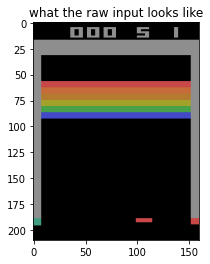

In [6]:
# Observations (raw)
env = make_atari("BreakoutNoFrameskip-v4")
obs = np.array(env.reset())
print(obs.shape)
plt.title("what the raw input looks like")
plt.imshow(obs)

(84, 84, 4)


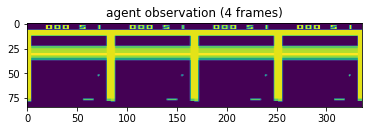

In [7]:
# Obseravtions (wrapped)
env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs = np.array(env.reset())

print(obs.shape)
plt.title("agent observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

In [ ]:
# Actions
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


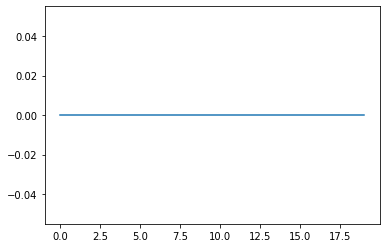

In [9]:
# Rewards
env.reset()
rewards = []
while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

__3.Create a model - Deep convolutional neural network__

In [10]:
num_actions = 4
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Target model
model_target = create_q_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

__4.Configuring the parameters and model training__

In [ ]:
gamma = 0.8  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 5000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 10

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.7, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

In [ ]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        if frame_count < epsilon_greedy_frames:
          epsilon -= epsilon_interval_1 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_1)
        
        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_2 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_2)
        
        if frame_count > 2 * epsilon_greedy_frames:
          epsilon -= epsilon_interval_3 / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min_3)
          

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every 20th frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 18:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
running reward: 0.29 at episode 25310, frame count 840000, epsilon 0.328, loss 0.05286
1/1 [==============================] - 0s 37ms/step
running reward: 0.31 at episode 25594, frame count 850000, epsilon 0.320, loss 0.07770
1/1 [==============================] - 0s 33ms/step
running reward: 0.19 at episode 25906, frame count 860000, epsilon 0.312, loss 0.13305
1/1 [==============================] - 0s 37ms/step
running reward: 0.21 at episode 26218, frame count 870000, epsilon 0.304, loss 0.03863
1/1 [==============================] - 0s 38ms/step
running reward: 0.25 at episode 26538, frame count 880000, epsilon 0.296, loss 0.05431
1/1 [==============================] - 0s 35ms/step


__5.Evaluating and saving the model__

In [1]:
# Saving the model
#model_name = 'breakout_model_1'
#path = F"/content/gdrive/MyDrive/models/{model_name}" 
#model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)

model_name = 'breakout_alpha_progress_21.44'
path = F"/content/gdrive/MyDrive/{model_name}" 
model = tf.keras.models.load_model(path)

NameError: ignored

__6.Making videos of our agent play__

In [ ]:
def make_env():
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

In [ ]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid1", force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

for i_episode in range(1):
    reward_window=[] 
    epsilon = 0  
    for t in range(4000):
        
        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          state_tensor = tf.convert_to_tensor(observation)
          state_tensor = tf.expand_dims(state_tensor, 0)
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()
        
        observation, reward, done, info = env.step(action)
        hits.append(reward)
        reward_window.append(reward)
        if len(reward_window) > 200:
          del reward_window[:1] 
        if len(reward_window) == 200 and np.sum(reward_window) == 0:
          epsilon = 0.01
        else:
          epsilon = 0.0001

        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)

        
        if done:
            print("Lost one life after {} timesteps".format(t+1))
            print(info)
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()

            epsilon_history = []
            reward_signal_history = []
            
            bltd = bltd-np.sum(hits)
            hits = []
            print("Bricks left to destroy ", bltd)
            if info['ale.lives'] == 0:
              break

            env.reset()
env.close()

# Questions

__1. Establish a baseline performance. How well did your Deep Q-learning do on your problem?__

Baseline performance: Gamma is 0.8, epsilon from 1.0 to 0.02, learning rate is 0.7 and max memory length is 5000.

In [11]:
gamma = 0.8  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 5000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 10

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.7, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

__2. What are the states, the actions, and the size of the Q-table?__

Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [8]:
# Actions
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


__3. What are the rewards? Why did you choose them?__

Score from the game is the rewards.

__4. How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?__

The equation consists of three elements:
the max function which picks the action that maximizes the reward (max_a)
the discount factor - the hyperparameter that can be tuned to emphasize the long-term reward or make the model focus on low hanging fruits and encourage to pick the best short-term solution. (gamma)
the function that calculates the reward given the selected action and the current state (R(s,a))

__5. Try a policy other than e-greedy. How did it change the baseline performance?__

__6. How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode?__

__7. What is the average number of steps taken per episode?__

In [ ]:
gamma = 0.8  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 5000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 10

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.7, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

10000.

__8. Does Q-learning use value-based or policy-based iteration?__

Q learning is a value-based off-policy temporal difference (TD) reinforcement learning.Off-policy means an agent follows a behaviour policy for choosing the action to reach the next state s_t+1 from state s_t. From s_t+1, it uses a policy π that is different from behaviour policy. In Q-learning, we take absolute greedy action as policy π from the next state s_t+1.

__9. Could you use SARSA for this problem?__

__10. What is meant by the expected lifetime value in the Bellman equation?__

The bellman expectation equation tells you the value for a given state (assuming a given policy). In other words, it tells you that if you start in a particular state, and follow a particular policy, you can expect this much return. So, it tells you how much return you can expect starting from each of your states and following the given policy.

__11. When would SARSA likely do better than Q-learning?__

If your goal is to train an optimal agent in simulation, or in a low-cost and fast-iterating environment, then Q-learning is a good choice, due to the first point (learning optimal policy directly). If your agent learns online, and you care about rewards gained whilst learning, then SARSA may be a better choice.

__12. How does SARSA differ from Q-learning?__

SARAS is on-policy while Q-learning is off-policy. While SARSA learns the Q values associated with taking the policy it follows itself, Q-learning learns the Q values associated with taking the optimal policy while following an exploration/exploitation policy.

__13. Explain the Q-learning algorithm.__

Q-Learning is based on the notion of a Q-function. The Q-function (a.k.a the state-action value function) of a policy  π ,  Qπ(s,a)  measures the expected return or discounted sum of rewards obtained from state  s  by taking action  a  first and following policy  π  thereafter. 

__14. Explain the SARSA algorithm.__

A SARSA agent interacts with the environment and updates the policy based on actions taken, hence this is known as an on-policy learning algorithm. The Q value for a state-action is updated by an error, adjusted by the learning rate alpha. Q values represent the possible reward received in the next time step for taking action a in state s, plus the discounted future reward received from the next state-action observation.

# License

Released under MIT License

Copyright (c) 2022 Junyang Luo.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.